# 모델 튜닝 & 결과저장

In [208]:
import time
import joblib
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.utils import compute_sample_weight
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, r2_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from xgboost import XGBRegressor
from xgboost import XGBClassifier

import tensorflow.keras as keras
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

import optuna
import plotly
import shap

## data1 : Regression Model

### 데이터 불러오기

In [2]:

    
df1 = pd.read_csv('data/Regression_data.csv')
num_cols = list(df1.drop(columns=['Sex', 'Rings']))
cat_cols = ['Sex']
X = df1.drop('Rings', axis=1)
y = df1.Rings

data1_ct = make_column_transformer(
    (OneHotEncoder(sparse_output=False), cat_cols),
    (StandardScaler(), num_cols),
    remainder='passthrough'
)
data1_ct.set_output(transform='pandas')
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y,
                                                    test_size=.25,
                                                    random_state=42)

X1_train = data1_ct.fit_transform(X1_train)
X1_test = data1_ct.transform(X1_test)

train_ds = tf.data.Dataset.from_tensor_slices((X1_train, y1_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X1_test, y1_test))

train_ds = train_ds.cache().shuffle(5000).batch(32)
valid_ds = valid_ds.cache().batch(32)


### XGBoost 튜닝

In [3]:
# XGBRegressor 튜닝

def reg_xgb_model(trial, X_train, X_test, y_train, y_test):
    model_params = {
        'learning_rate':trial.suggest_float('learning_rate', 0.0001, 1.0, log=True),
        'n_estimators':trial.suggest_int('n_estimators', 100, 2000, step=50),
        'max_depth':trial.suggest_int('max_depth', 4, 20),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'reg_lambda':trial.suggest_float('l2', 0.001, 100.0, log=True),
        'reg_alpha':trial.suggest_float('l1', 0.001, 100.0, log=True),
        'gamma':trial.suggest_float('gamma', 0.001, 100.0, log=True),
    }

    model = XGBRegressor(random_state=42,
                         objective='reg:squarederror',
                         eval_metric='rmse',
                         tree_method='gpu_hist',
                         gpu_id=0,
                         early_stopping_rounds=30,
                         **model_params)
    
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=0)
    
    return model

def reg_xgb_objective(trial, X_train, X_test, y_train, y_test):
    
    model = reg_xgb_model(trial, X_train, X_test, y_train, y_test)
    rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)

    return rmse


# reg_xgb_study = optuna.create_study(
#     direction='minimize',
#     sampler=optuna.samplers.TPESampler()
# )

# reg_xgb_study.optimize(
#     lambda trial: reg_xgb_objective(trial, X1_train, X1_test, y1_train, y1_test),
#     n_trials=1000
# )

# joblib.dump(reg_xgb_study, 'data/reg_xgb_study.pkl')

In [5]:
if os.path.exists('data/reg_xgb_study.pkl'):
    reg_xgb_study = joblib.load('data/reg_xgb_study.pkl')
    
print(f'best rmse : {reg_xgb_study.best_trial.value}\nbest params : {reg_xgb_study.best_trial.params}')
optuna.visualization.plot_optimization_history(reg_xgb_study)

best rmse : 4.510030157037123
best params : {'learning_rate': 0.02087425763287998, 'n_estimators': 1550, 'max_depth': 17, 'colsample_bytree': 0.5, 'l2': 10.670146505870857, 'l1': 0.0663394675391197, 'gamma': 9.015017136084957}


### 모델 평가 및 해석

rmse : 2.124
acc : 0.852
r2 : 0.562


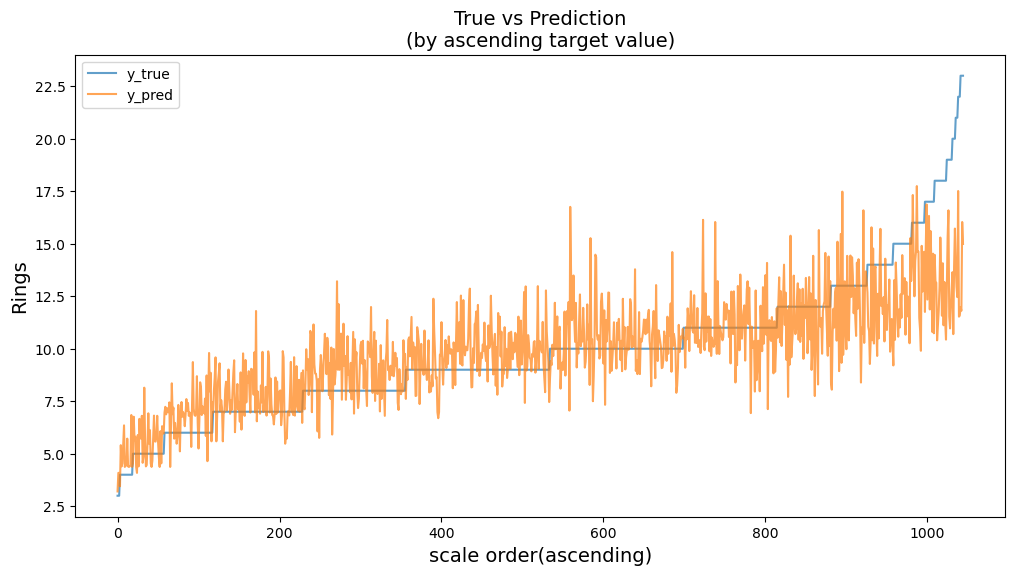

In [6]:
reg_xgb_best = reg_xgb_model(reg_xgb_study.best_trial, X1_train, X1_test, y1_train, y1_test)

def reg_performance(model, X_test, y_test=None, plot=False):
    y_pred = pd.Series(model.predict(X_test), index=y_test.index)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    acc = np.mean(1-abs((y_pred - y_test) / y_test))
    r2 = r2_score(y_test, y_pred)
    
    if plot==True:
        # y_test의 target 크기별 예측값이 어떤지 확인
        y_test = y_test.sort_values()
        y_pred = y_pred[y_test.index]

        print(f'rmse : {rmse:.3f}\nacc : {acc:.3f}\nr2 : {r2:.3f}')
        plt.figure(figsize=(12,6))
        plt.plot(y_test.reset_index(drop=True), alpha=0.7, label='y_true')
        plt.plot(y_pred.reset_index(drop=True), alpha=0.7, label='y_pred')
        plt.ylabel('Rings', fontsize=14)
        plt.xlabel('scale order(ascending)', fontsize=14)
        plt.title('True vs Prediction\n(by ascending target value)', fontsize=14)
        plt.legend()
        plt.show()
    else:
        return rmse, acc, r2

reg_performance(reg_xgb_best, X1_test, y1_test, plot=True)
# rmse 2.124,  acc 0.852
# Rings가 클수록 예측을 잘 못한다.
# Rings ~ 12 까지는 전체적으로 over estimation경향
# 그 이후론 under estimation

# best 모델에서 bias 살짝 감안하고 variance 줄이면 성능오를가능성
# 손실함수 rmsle사용으로 over estimation 경향늘리고 variance를 낮추는대신 bias를 증가시키면 될듯하다.

Text(0.5, 1.0, 'SHAP summary plot of BestModel')

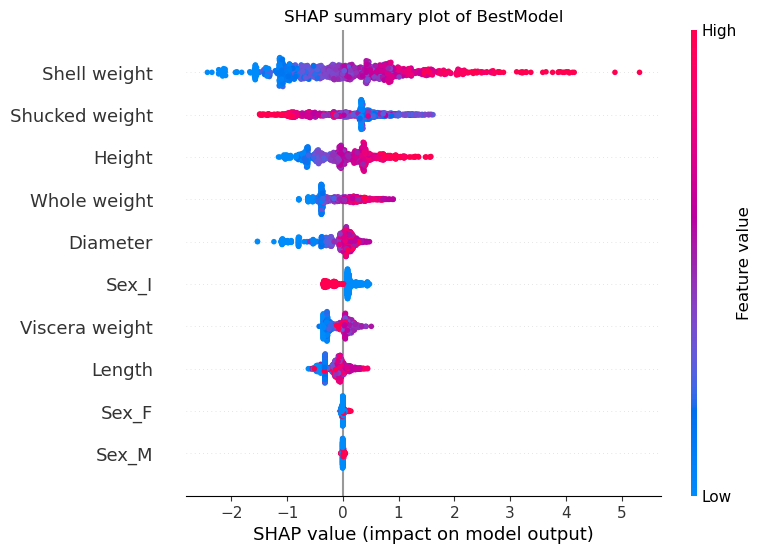

In [181]:
explainer = shap.TreeExplainer(reg_xgb_best,
                               feature_perturbation='interventional')
shap_values = explainer(X1_test)
feature_names = ['Sex_F', 'Sex_I', 'Sex_M', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
shap.summary_plot(shap_values, 
                  feature_names=feature_names,
                  show=False)
plt.title('SHAP summary plot of BestModel', fontsize=12)
# plt.show()


In [178]:
pi_series.index

Index(['onehotencoder__Sex_M', 'onehotencoder__Sex_F',
       'standardscaler__Viscera weight', 'standardscaler__Length',
       'onehotencoder__Sex_I', 'standardscaler__Diameter',
       'standardscaler__Height', 'standardscaler__Whole weight',
       'standardscaler__Shucked weight', 'standardscaler__Shell weight'],
      dtype='object')

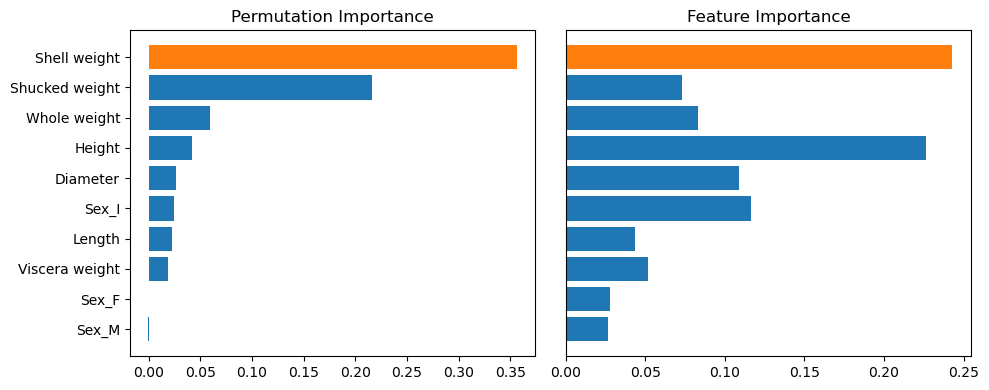

In [184]:
# Permutation importanc, PDP 그려보기
pi = permutation_importance(reg_xgb_best, X1_test, y1_test,
                            n_repeats=20,
                            random_state=42,
                            n_jobs=-1)

pi_series = pd.Series(pi.importances_mean, index=feature_names).sort_values()
fi_series = pd.Series(reg_xgb_best.feature_importances_, index=feature_names)[pi_series.index]
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.barh(pi_series.index, pi_series.values, color=['C1' if i==9 else 'C0' for i in range(10)])
plt.title('Permutation Importance', fontsize=12)
plt.subplot(122)
plt.barh(fi_series.index, fi_series.values, color=['C1' if i==9 else 'C0' for i in range(10)] )
plt.yticks([])
plt.title('Feature Importance', fontsize=12)
plt.tight_layout()
plt.show()
# Shell weight의 중요도가 둘모두 가장 높다.

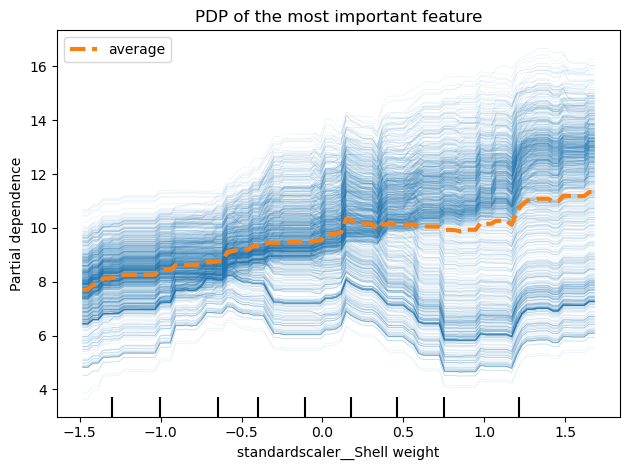

In [35]:
# 1way PDP 그려보기
PartialDependenceDisplay.from_estimator(reg_xgb_best,
                                        X=X1_test,
                                        features=[9],
                                        ice_lines_kw={'alpha':0.1},
                                        pd_line_kw={'linewidth':3},
                                        kind='both',
                                        n_jobs=-1)
plt.title('PDP of the most important feature', fontsize=12)
plt.tight_layout()
plt.show()
# Shell weight가 증가할수록 Rings 예측값 증가
# 다만 weight가 증가해도 예측값이 떨어지는(경향이 다른) ICE들이 꽤 있다.
# => Shell weight와 다른 feature들과의 상관관계가 강한편.
# 

In [37]:
# 모델 저장
# joblib.dump(reg_xgb_best, 'data/reg_BestModel.pkl')
# joblib.dump(data1_ct, 'data/reg_ct.pkl')

['data/reg_ct.pkl']

### 튜닝결과
* rmse : 2.124
* acc : 0.852
* r2 : 0.562

## data2 : Binary-classification Model

### 데이터 불러오기

In [214]:
data2_ct = None

df2 = pd.read_csv('data/binary_classification_data.csv')

data2_ct = StandardScaler()
data2_ct.set_output(transform='pandas')

X = df2.drop(columns='target_class')
y = df2.target_class

X2_train, X2_test, y2_train, y2_test = train_test_split(X,y,
                                                    test_size=.25,
                                                    stratify=y,
                                                    random_state=42)

X2_train = data2_ct.fit_transform(X2_train)
X2_test = data2_ct.transform(X2_test)
# SMOTEENN 샘플링은 하이퍼파라미터가 있으므로 optuna 튜닝시 진행

train_ds = tf.data.Dataset.from_tensor_slices((X2_train, y2_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X2_test, y2_test))

train_ds = train_ds.cache().shuffle(15000).batch(32)
valid_ds = valid_ds.cache().batch(32)

### XGBoost 튜닝

In [4]:
# XGBClassifier 튜닝

def bin_xgb_model(trial, X_train, X_test, y_train, y_test):
    # 먼저 SMOTEENN 샘플링
    # smote = SMOTE(sampling_strategy='minority',
    #               k_neighbors=trial.suggest_int('smote_k', 2, 20, step=1),
    #               random_state=42)
    # enn = EditedNearestNeighbours(sampling_strategy='majority',
    #                               n_neighbors=trial.suggest_int('enn_k', 2, 20, step=1),
    #                               kind_sel='mode')
    # smoteenn = SMOTEENN(smote=smote,
    #                     enn=enn,
    #                     random_state=42)
    
    # X_train, y_train = smoteenn.fit_resample(X_train, y_train)

    # 모델 생성 및 학습
    model_params = {
        'learning_rate':trial.suggest_float('learning_rate', 0.0001, 1.0, log=True),
        'n_estimators':trial.suggest_int('n_estimators', 100, 1500, step=100),
        'max_depth':trial.suggest_int('max_depth', 4, 20),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'reg_lambda':trial.suggest_float('l2', 0.001, 100.0, log=True),
        'reg_alpha':trial.suggest_float('l1', 0.001, 100.0, log=True),
        'gamma':trial.suggest_float('gamma', 0.001, 100.0, log=True),
        'scale_pos_weight':trial.suggest_float('scale_pos_weight', 5.0, 15.0, step=0.1)
    }
    
    model = XGBClassifier(random_state=42,
                          objective='binary:logistic',
                          eval_metric='aucpr',
                          tree_method='gpu_hist',
                          gpu_id=0,
                          early_stopping_rounds=30,
                          **model_params)
        
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=0)
    
    return model

def bin_xgb_objective(trial, X_train, X_test, y_train, y_test):
    
    model = bin_xgb_model(trial, X_train, X_test, y_train, y_test)
    f1 = f1_score(y_test, model.predict(X_test), pos_label=1)
    return f1


# bin_xgb_study = optuna.create_study(
#     direction='maximize',
#     # CMA-ES 샘플러 :
#     # 튜닝할 파라미터가 전부 수치형이고, 파라미터가 많고,
#     # n_trial규모가 클때 TPE보다 일반적으로 좋다.
#     # => IPOP-CMA-ES 샘플러 사용
#     sampler=optuna.samplers.CmaEsSampler(
#         restart_strategy='ipop',
#         inc_popsize=2
#     )
# )

# bin_xgb_study.optimize(
#     lambda trial: bin_xgb_objective(trial, X2_train, X2_test, y2_train, y2_test),
#     n_trials=2000 # CMA-ES이므로 넉넉하게 설정
# )

# # 기존 성능 f1 ~ 0.894
# joblib.dump(bin_xgb_study, 'data/bin_xgb_study.pkl')

In [43]:
if os.path.exists('data/bin_xgb_study.pkl'):
    bin_xgb_study = joblib.load('data/bin_xgb_study.pkl')
    
print(f'best rmse : {bin_xgb_study.best_trial.value}\nbest params : {bin_xgb_study.best_trial.params}')
optuna.visualization.plot_optimization_history(bin_xgb_study)

best rmse : 0.8704784130688449
best params : {'smote_k': 2, 'enn_k': 6, 'learning_rate': 0.03233685808565227, 'n_estimators': 1200, 'max_depth': 20, 'colsample_bytree': 0.5, 'l2': 0.004666963217784473, 'l1': 0.002792083422830542, 'gamma': 0.036934880241175236, 'scale_pos_weight': 7.0}


In [6]:
bin_xgb_best = bin_xgb_model(bin_xgb_study.best_trial, X2_train, X2_test, y2_train, y2_test)

print(classification_report(y2_test, bin_xgb_best.predict(X2_test), digits=4))
# 오히려 1의 f1 성능이 더 떨어졌다. 뭐가 문제일까.

              precision    recall  f1-score   support

           0     0.9908    0.9818    0.9863      4065
           1     0.8345    0.9098    0.8705       410

    accuracy                         0.9752      4475
   macro avg     0.9126    0.9458    0.9284      4475
weighted avg     0.9765    0.9752    0.9757      4475



In [215]:
# recall_score(y2_test, model.predict(X2_test)).round(3)
# model.predict_proba(X2_test)[:,1]

def prec_recall(model, X_test, y_test, delta=0):
    precision, recall, th = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1],
                                                   pos_label=1)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    best = np.argmax(f1) + delta
    return precision[best], recall[best], f1[best], th[best]


# precision, recall, f1, th = prec_recall(model, X2_test, y2_test, delta=0)

# print(f'precision : {precision:.3f}\nrecall : {recall:.3f}\nf1 : {f1:.3f}\nth : {th:.3f}')

In [211]:
# SMOTEENN 없이 진행, 샘플웨이트 설정
from sklearn.utils import compute_sample_weight


def bin_xgb_model2(trial, X_train, X_test, y_train, y_test):
    model_params = {
        'learning_rate':trial.suggest_float('learning_rate', 0.0001, 1.0, log=True),
        'n_estimators':trial.suggest_int('n_estimators', 100, 1500, step=100),
        'max_depth':trial.suggest_int('max_depth', 4, 20),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'reg_lambda':trial.suggest_float('l2', 0.001, 100.0, log=True),
        'reg_alpha':trial.suggest_float('l1', 0.001, 100.0, log=True),
        'gamma':trial.suggest_float('gamma', 0.001, 100.0, log=True),
        'scale_pos_weight':trial.suggest_float('scale_pos_weight', 0.5, 15.0, step=0.1)
    }
    
    model = XGBClassifier(random_state=42,
                          objective='binary:logistic',
                          eval_metric='aucpr',
                          tree_method='gpu_hist',
                          gpu_id=0,
                          early_stopping_rounds=50)
    
    model.set_params(**model_params)
    weight = compute_sample_weight(class_weight='balanced', y=y_train)
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              sample_weight=weight,
              verbose=0)
    
    return model

def bin_xgb_objective(trial, X_train, X_test, y_train, y_test):
    
    model = bin_xgb_model2(trial, X_train, X_test, y_train, y_test)
    f1 = f1_score(y_test, model.predict(X_test), pos_label=1)
    return f1

In [ ]:
bin_xgb_study2 = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.CmaEsSampler(
        restart_strategy='ipop',
        inc_popsize=2
    )
)

# bin_xgb_study2.optimize(
#     lambda trial: bin_xgb_objective(trial, X2_train, X2_test, y2_train, y2_test),
#     n_trials=1000
# )

# joblib.dump(bin_xgb_study2, 'data/bin_xgb_study2.pkl')

In [209]:
if os.path.exists('data/bin_xgb_study2.pkl'):
    bin_xgb_study2 = joblib.load('data/bin_xgb_study2.pkl')
    
print(f'best f1 : {bin_xgb_study2.best_trial.value}\nbest params : {bin_xgb_study2.best_trial.params}')
optuna.visualization.plot_optimization_history(bin_xgb_study2)

best f1 : 0.8927250308261406
best params : {'learning_rate': 0.07599786434716908, 'n_estimators': 1400, 'max_depth': 19, 'colsample_bytree': 0.5, 'l2': 0.007915306338055306, 'l1': 0.007964684761239524, 'gamma': 0.008710642511159737, 'scale_pos_weight': 0.9}


### 모델 평가 및 해석

In [216]:
bin_xgb_best = bin_xgb_model2(bin_xgb_study2.best_trial, X2_train, X2_test, y2_train, y2_test)

precision, recall, f1, th = prec_recall(bin_xgb_best, X2_test, y2_test, delta=0)

pred = bin_xgb_best.predict_proba(X2_test)[:,1]
# pred = bin_xgb_best.predict(X2_test)
print(classification_report(y2_test, pred >= th, digits=3))
# SMOTEENN 제거 이후 0.896까지는 나왔다. : th 0.60423

              precision    recall  f1-score   support

           0      0.988     0.991     0.990      4065
           1      0.912     0.880     0.896       410

    accuracy                          0.981      4475
   macro avg      0.950     0.936     0.943      4475
weighted avg      0.981     0.981     0.981      4475



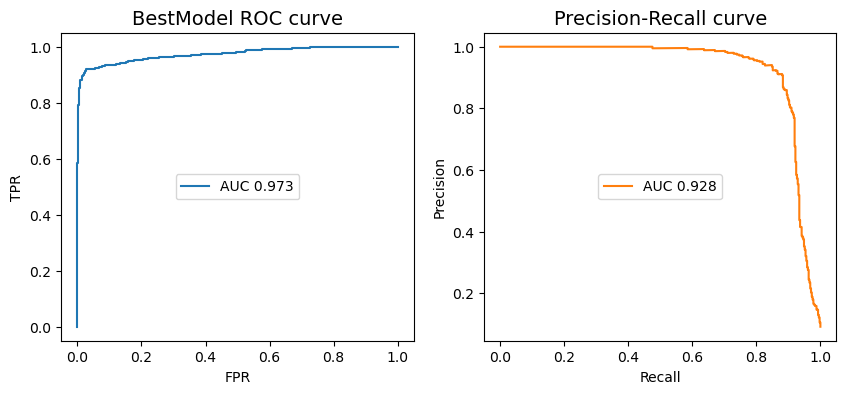

In [212]:
# ROC커브, PR커브 그리기

fpr, tpr, _ = roc_curve(y2_test, pred, pos_label=1)
precision, recall, _  = precision_recall_curve(y2_test, pred, pos_label=1,
                                               drop_intermediate=True)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(fpr, tpr, label=f'AUC {auc(fpr,tpr):.3f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='center')
plt.title('BestModel ROC curve', fontsize=14)
plt.subplot(122)
plt.plot(recall, precision, label=f'AUC {auc(recall, precision):.3f}', c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='center')
plt.title('Precision-Recall curve', fontsize=14)
plt.show()

c:\Users\dynam\anaconda3\envs\TP1\Lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



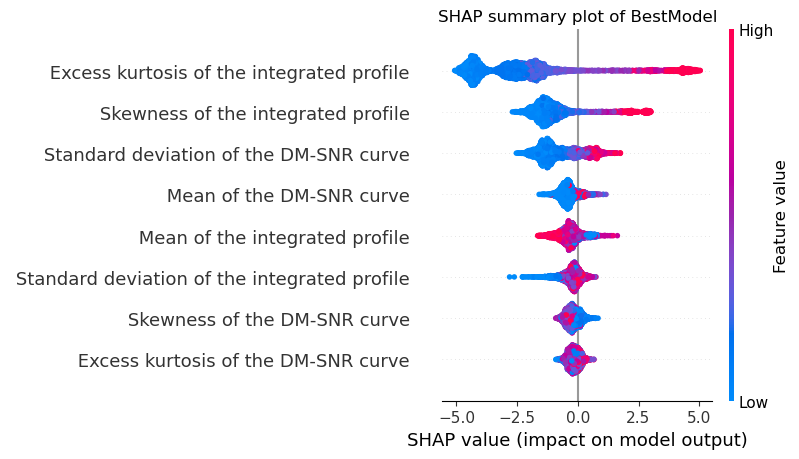

Text(0.5, 1.0, 'SHAP summary plot of BestModel')

In [122]:
explainer = shap.TreeExplainer(bin_xgb_best,
                               feature_perturbation='interventional')
shap_values = explainer(X2_test)
shap.summary_plot(shap_values)
plt.title('SHAP summary plot of BestModel', fontsize=12)

# integrated profile의 kurtosis와 skewness가 증가할수록, mean이 감소할수록 펄사로 예측한다.

In [147]:
# Permutation importanc, PDP 그려보기
pi = permutation_importance(bin_xgb_best, X2_test, y2_test,
                            n_repeats=20,
                            random_state=42,
                            n_jobs=-1)

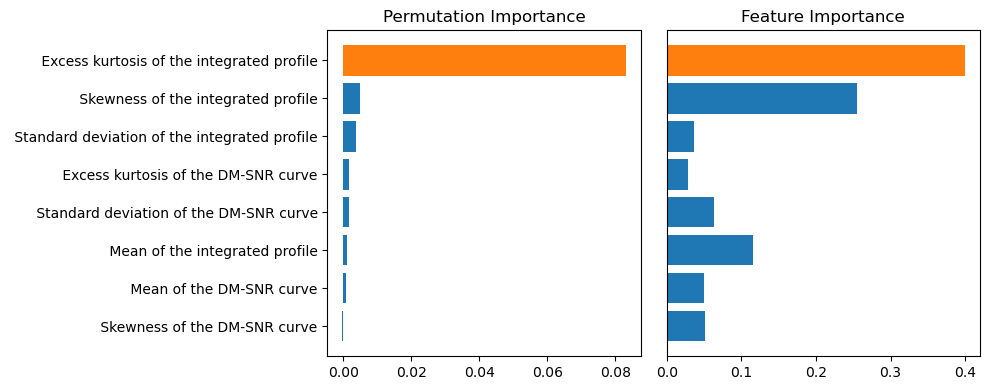

In [220]:
pi_series = pd.Series(pi.importances_mean, index=X2_test.columns).sort_values()
fi_series = pd.Series(bin_xgb_best.feature_importances_, index=X2_test.columns)[pi_series.index]
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.barh(pi_series.index, pi_series.values, color=['C1' if i==7 else 'C0' for i in range(8)] )
plt.title('Permutation Importance', fontsize=12)
plt.subplot(122)
plt.barh(fi_series.index, fi_series.values, color=['C1' if i==7 else 'C0' for i in range(8)] )
plt.yticks([])
plt.title('Feature Importance', fontsize=12)
plt.tight_layout()
plt.show()
# Excess kurtosis of the intgrated profile의 중요도가 가장 높다.

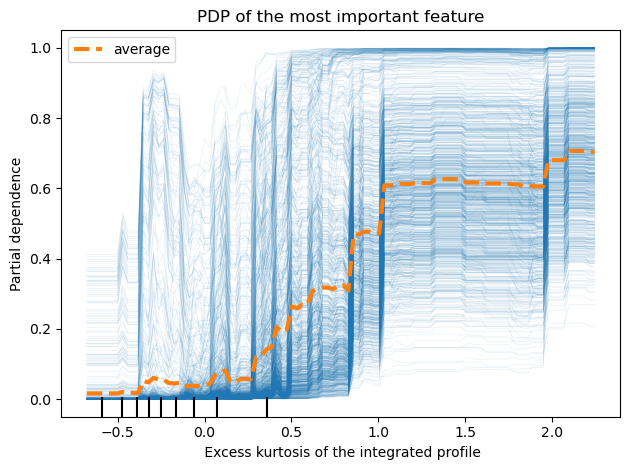

In [124]:
# 1way PDP 그려보기
PartialDependenceDisplay.from_estimator(bin_xgb_best,
                                        X=X2_test,
                                        features=[2],
                                        ice_lines_kw={'alpha':0.1},
                                        pd_line_kw={'linewidth':3},
                                        kind='both',
                                        n_jobs=-1)
plt.title('PDP of the most important feature', fontsize=12)
plt.tight_layout()
plt.show()
# 값이 증가할수록 펄사일 확률도 높게 예측된다.
# -0.5 ~ 0 사이에 대부분의 값들이 몰려있다.
# 몇개 예시에서 -0.5 ~ 0에서의 움직임이 살짝다른 케이스들이 있다.
#   => 처음엔 다른 feature와 상호작용이 있다가, 0.5 이상이면 독립적인 영향력을 미친다.
# 1.0 이상에서 ICE의 편차가 크다. (경향은 동일)
#   => feature중에 영향력은 가장높지만, 이거하나만으로 펄사를 판단하긴 힘들다.

In [220]:
#모델 저장
# joblib.dump(bin_xgb_best, 'data/bin_BestModel.pkl')
# joblib.dump(data2_ct, 'data/bin_ct.pkl')

['data/bin_BestModel.pkl']

### 튜닝결과
* 정확도 : 0.981
* 1의 f1 : 0.896

## data3 : Multi-classification Model

### 데이터 불러오기 및 함수 정의

In [36]:
# preprocessing.ipynb의 결과에 따라 전처리
# 함수로 만들어서 진행 : multiple_load_dataset()

def multiple_load_dataset(tf_dataset=False):
    """
    data3을 불러와서 전처리된 데이터셋을 반환  

    전처리:  
    1. A400컬럼 드랍 drop
    2. 범주형 원핫인코딩
    3. 수치형 표준화

    args:
        tf_dataset : True인경우 tf.Dataset 반환
    
    returns:
        if tf_dataset is True : train_ds, valid_ds
        else : X_train, X_test, y_train, y_test
    """
    
    # 추후 ct를 불러오기위해 전역변수로 설정
    global data3_ct

    df3 = pd.read_csv('data/mulit_classification_data.csv')

    # A300과 A400의 상관계수 1 => A400컬럼 제거 
    target = df3.loc[:,'Pastry':'Other_Faults'].columns
    X = df3.drop(columns='TypeOfSteel_A400')
    X = X.drop(columns=target, axis=1)
    y = df3[target].copy()
    y['label'] = np.argmax(y.values, axis=1) # label구분을 위한 컬럼추가

    # 범주형 : TypeOfSteel_A300, Outside_Global_Index
    cat_cols = ['TypeOfSteel_A300', 'Outside_Global_Index']
    num_cols = list(X.drop(columns=cat_cols))

    # 범주형 ohe, 나머지 표준화
    data3_ct = make_column_transformer(
        (StandardScaler(), num_cols),
        (OneHotEncoder(sparse_output=False, drop='if_binary'), cat_cols),
        remainder='passthrough'
    )
    data3_ct.set_output(transform='pandas')

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.25,
                                                        stratify=y['label'],
                                                        random_state=42)
    # 독립변수 28개, 종속변수 7개
    X_train = data3_ct.fit_transform(X_train)
    X_test = data3_ct.transform(X_test)

    if tf_dataset:
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train.drop('label', axis=1)))
        valid_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test.drop('label', axis=1)))

        train_ds = train_ds.cache().shuffle(2000).batch(32)
        valid_ds = valid_ds.cache().batch(32)
        return train_ds, valid_ds
    else:
        return X_train, X_test, y_train, y_test

X3_train, X3_test, y3_train, y3_test = multiple_load_dataset()
y3_true = y3_test.drop('label', axis=1)

# modelA 데이터 (Other_Faults 0, 1 라벨)
y3_trainA = y3_train.Other_Faults
y3_testA = y3_test.Other_Faults

# modelB 데이터 (Other_Faults제외 6개 결함 라벨)
y3_trainB = y3_train[y3_train.Other_Faults == 0].label
y3_testB = y3_test[y3_test.Other_Faults == 0].label
X3_trainB = X3_train.loc[y3_trainB.index]
X3_testB = X3_test.loc[y3_testB.index]

train_ds, valid_ds = multiple_load_dataset(tf_dataset=True)

In [3]:
# 콜백 정의 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5, patience=15,
                                                 verbose=0, mode='auto')
e_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=40,
                                          restore_best_weights=True)

def multiple_nn_prediction(model, X_valid):
    # X_valid에 valid_ds 넣으면 X_valid로 자동변환
    if isinstance(X_valid, tf.data.Dataset):
        X_valid = np.array([i for i, _ in valid_ds.unbatch()])

    pred = model.predict(X_valid, verbose=False)
    max_val = np.max(pred, axis=1, keepdims=True)
    pred = np.where(pred == max_val, 1, 0)
    return pred

def multiple_nn_performance(model, hist, valid_ds):
    
    plt.plot(hist.history['prc'], label='train')
    plt.plot(hist.history['val_prc'], label='val')
    plt.ylabel('AUCR-PR')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    y_true = np.array([i.numpy() for _, i in valid_ds.unbatch()])
    X_valid = np.array([i for i, _ in valid_ds.unbatch()])
    y_pred = multiple_nn_prediction(model, X_valid)
    target_names = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

    print(classification_report(y_true, y_pred, target_names=target_names))

### 신경망 모델 튜닝

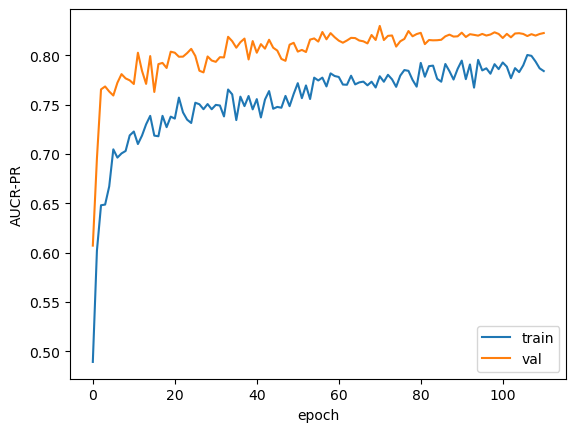

              precision    recall  f1-score   support

      Pastry       0.56      0.62      0.59        39
   Z_Scratch       0.77      0.85      0.81        48
    K_Scatch       0.97      0.95      0.96        98
      Stains       0.85      0.94      0.89        18
   Dirtiness       0.70      0.50      0.58        14
       Bumps       0.60      0.67      0.64       101
Other_Faults       0.68      0.61      0.64       168

   micro avg       0.72      0.72      0.72       486
   macro avg       0.73      0.73      0.73       486
weighted avg       0.73      0.72      0.72       486
 samples avg       0.72      0.72      0.72       486



In [53]:
# 기본모델 : 16 => 32 => 16 => 7(out)
m_model = tf.keras.Sequential([
        keras.layers.Dense(16),
        keras.layers.Dropout(0.5),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(32),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(16),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(7, activation='softmax')
    ])
m_model.compile(loss='categorical_crossentropy',
                  metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                  optimizer=keras.optimizers.Adam(0.01))
    
hist = m_model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=200,
                    callbacks=[e_stop, reduce_lr],
                    verbose=0)

multiple_nn_performance(m_model, hist, valid_ds)
# acc ~ 0.72
# f1 ~ 0.73

In [ ]:

# optuna 튜닝과정
# objective함수를 정의하하고 study를 생성합니다.
# objective함수는 각 trial마다 호출되서 trial의 suggest값이 대입됩니다.
# sutdy.optimize를 하게되면 objective의 return값을 maximize하거나 minimize 하는식으로 학습합니다.

# objective : 모델 넣고 최소화 하거나 최대화할 metric 반환
# trial : 각 시도마다 옵튜나에서 알아서 넣을 값들. 즉 튜닝대상 하이퍼파라미터
# trial종류
#   1. trial.suggest_int(name, low, high) : low부터 high까지의 정수
#   2. trial.suggest_float(name, low, high, step, log) : low부터 high까지 실수. log=True면 로그범위로 선택
# study : 최적화를 진행하고 결과를 기록하는 객체

def nn_objective(trial):
    global train_ds
    global valid_ds
    global reduce_lr
    global e_stop
    global y_true

    n_layers = trial.suggest_int('n_layers',2, 8)
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=[28,]))
    for i in range(n_layers):
        node = trial.suggest_int(f'layer{i}_node', 4, 128, log=True)
        drop_rate = trial.suggest_float(f'layer{i}_dropout', 0.3, 0.9, step=0.1)
        model.add(keras.layers.Dense(node))
        model.add(keras.layers.Dropout(drop_rate))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(7, activation='softmax'))

    lr = trial.suggest_float('eta', 1e-4, 1e-2, log=True)
    model.compile(loss='categorical_crossentropy',
                  metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                  optimizer=keras.optimizers.Adam(0.01))
    
    hist = model.fit(train_ds,
                     validation_data=valid_ds,
                     epochs=300,
                     callbacks=[e_stop, reduce_lr],
                     verbose=0)
    
    y_pred = multiple_nn_prediction(model, valid_ds)
    micro_f1 = f1_score(y_true, y_pred, average='micro')

    return micro_f1

study = optuna.create_study(direction='maximize')
study.optimize(nn_objective, n_trials=500)

joblib.dump(study, 'multiple_nn_tuning.pkl')

In [4]:
# if os.path.exists('multiple_nn_tuning.pkl'):
#     study = joblib.load('multiple_nn_tuning.pkl')
    
print(f'best f1 : {study.best_trial.value}\nbest params : {study.best_trial.params}')
optuna.visualization.plot_optimization_history(study)

best f1 : 0.7736625514403292
best params : {'n_layers': 2, 'layer0_node': 108, 'layer0_dropout': 0.3, 'layer1_node': 7, 'layer1_dropout': 0.3, 'eta': 0.0021096691683225853}


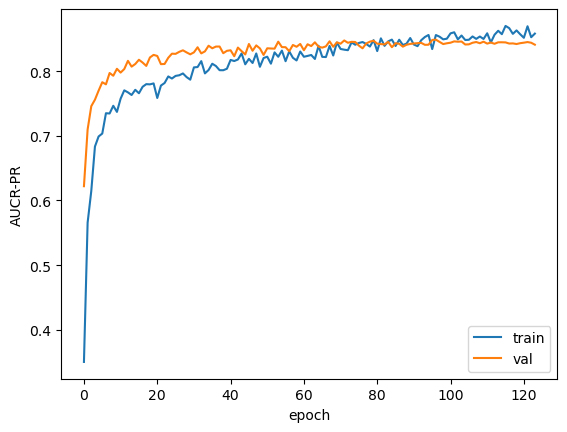

              precision    recall  f1-score   support

      Pastry       0.59      0.62      0.60        39
   Z_Scratch       0.84      0.85      0.85        48
    K_Scatch       0.98      0.96      0.97        98
      Stains       1.00      0.94      0.97        18
   Dirtiness       0.67      0.57      0.62        14
       Bumps       0.62      0.69      0.65       101
Other_Faults       0.69      0.65      0.67       168

   micro avg       0.75      0.75      0.75       486
   macro avg       0.77      0.76      0.76       486
weighted avg       0.75      0.75      0.75       486
 samples avg       0.75      0.75      0.75       486



In [12]:
def multiple_nn_bestmodel(trial):
    global train_ds
    global valid_ds
    global reduce_lr
    global e_stop
    global y_true

    n_layers = trial.suggest_int('n_layers',2, 8)
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=[28,]))
    for i in range(n_layers):
        node = trial.suggest_int(f'layer{i}_node', 4, 128, log=True)
        drop_rate = trial.suggest_float(f'layer{i}_dropout', 0.3, 0.9, step=0.1)
        model.add(keras.layers.Dense(node))
        model.add(keras.layers.Dropout(drop_rate))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(7, activation='softmax'))

    lr = trial.suggest_float('eta', 1e-4, 1e-2, log=True)
    model.compile(loss='categorical_crossentropy',
                  metrics=[keras.metrics.AUC(name='prc', curve='PR')],
                  optimizer=keras.optimizers.Adam(0.01))
    
    hist = model.fit(train_ds,
                     validation_data=valid_ds,
                     epochs=300,
                     callbacks=[e_stop, reduce_lr],
                     verbose=0)
    return model, hist
    
m_model2, hist = multiple_nn_bestmodel(study.best_trial)
multiple_nn_performance(m_model2, hist, valid_ds)

# 신경망 모델의 성능이 생각보다 높지 않다.

### XGBoost 튜닝

In [44]:
# Other_Faults 분리해서 xgboost로 튜닝
# 첫 번째 모델 (modelA): Other_Faults인지 아닌지 분류
# 두 번째 모델 (modelB): Other_Faults가 아니면 다중분류

def multiple_xgb_model(trial, X_train, X_test, y_train, y_test, case='A'):
    model_params = {
        'learning_rate':trial.suggest_float('learning_rate', 0.0001, 1.0, log=True),
        'n_estimators':trial.suggest_int('n_estimators', 100, 2000, step=10),
        'max_depth':trial.suggest_int('max_depth', 4, 20),
        'colsample_bytree':trial.suggest_float('colsample_bytree', 0.2, 1.0, step=0.1),
        'reg_lambda':trial.suggest_float('l2', 0.001, 100.0, log=True),
        'reg_alpha':trial.suggest_float('l1', 0.001, 100.0, log=True),
        'gamma':trial.suggest_float('gamma', 0.001, 100.0, log=True),
    }
    # 이진분류 케이스
    if case == 'A':
        # 파라미터 scalse_pos_weight 추가
        model_params['scale_pos_weight'] = trial.suggest_float('scale_pos_weight', 1.0, 5.0, step=0.1)

        modelA = XGBClassifier(random_state=42,
                               objective='binary:logistic',
                               eval_metric='error',
                               tree_method='gpu_hist',
                               gpu_id=0,
                               early_stopping_rounds=30,
                               **model_params)
        
        modelA.fit(X_train, y_train,
                   eval_set=[(X_test, y_test)],
                   verbose=0)
        
        return modelA
    # 다중분류 케이스
    elif case == 'B':
        # 다중분류는 scale_pos_weight 설정이 불가함으로 sklearn을 활용,
        # sample weight로 weight 설정
        weight = compute_sample_weight(class_weight='balanced', y=y_train)

        modelB = XGBClassifier(random_state=42,
                               objective='multi:softprob',
                               eval_metric='aucpr',
                               tree_method='gpu_hist',
                               gpu_id=0,
                               early_stopping_rounds=30,
                               num_class=6,
                               **model_params)
        
        modelB.fit(X_train, y_train,
                   eval_set=[(X_test, y_test)],
                   sample_weight=weight,
                   verbose=0)
        
        return modelB


def multiple_xgb_objective(trial, X_train, X_test, y_train, y_test, case='A'):
    
    model = multiple_xgb_model(trial, X_train, X_test, y_train, y_test, case)
    
    if case == 'A':
        acc = accuracy_score(y_test, model.predict(X_test))
        return acc
    elif case == 'B':
        micro_f1 = f1_score(y_test, model.predict(X_test), average='micro')
        return micro_f1


# multiple_modelA_study = optuna.create_study(
#     direction='maximize',
#     sampler=optuna.samplers.TPESampler()
# )

# multiple_modelA_study.optimize(
#     lambda trial: multiple_xgb_objective(trial, X_train, X_test, y_trainA, y_testA, case='A'),
#     n_trials=2000
# )

# joblib.dump(multiple_modelA_study, 'multiple_modelA_tuning.pkl')

In [39]:
if os.path.exists('data/multiple_modelA_tuning.pkl'):
    multiple_modelA_study = joblib.load('data/multiple_modelA_tuning.pkl')
    
print(f'best acc : {multiple_modelA_study.best_trial.value}\nbest params : {multiple_modelA_study.best_trial.params}')

multiple_modelA = multiple_xgb_model(multiple_modelA_study.best_trial, X3_train, X3_test, y3_trainA, y3_testA)
print(classification_report(y3_testA, multiple_modelA.predict(X3_test)))

optuna.visualization.plot_optimization_history(multiple_modelA_study)

best acc : 0.8436213991769548
best params : {'learning_rate': 0.012202469692864067, 'n_estimators': 700, 'max_depth': 11, 'colsample_bytree': 0.7, 'l2': 0.6998936289657887, 'l1': 0.07423629936782049, 'gamma': 0.04343495370664839, 'scale_pos_weight': 1.2}
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       318
           1       0.83      0.68      0.75       168

    accuracy                           0.84       486
   macro avg       0.84      0.81      0.82       486
weighted avg       0.84      0.84      0.84       486



In [40]:
multiple_modelB_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler()
)

# multiple_modelB_study.optimize(
#     lambda trial: multiple_xgb_objective(trial, X_trainB, X_testB, y_trainB, y_testB, case='B'),
#     n_trials=1000
# )

# joblib.dump(multiple_modelB_study, 'multiple_modelB_tuning.pkl')

[I 2023-07-30 02:47:20,458] A new study created in memory with name: no-name-2dc36f9d-a503-41b9-9cb6-9e275c3828fb


In [194]:
if os.path.exists('data/multiple_modelB_tuning.pkl'):
    multiple_modelB_study = joblib.load('data/multiple_modelB_tuning.pkl')
    
print(f'best acc : {multiple_modelB_study.best_trial.value}\nbest params : {multiple_modelB_study.best_trial.params}')

multiple_modelB = multiple_xgb_model(multiple_modelB_study.best_trial, X3_trainB, X3_testB, y3_trainB, y3_testB, case='B')
print(classification_report(y3_testB, multiple_modelB.predict(X3_testB)))

optuna.visualization.plot_optimization_history(multiple_modelB_study)
# 결과가 상당히 괜찮게 나왔다!

              precision    recall  f1-score   support

           0       0.77      0.87      0.82        39
           1       0.94      1.00      0.97        48
           2       0.99      0.99      0.99        98
           3       1.00      0.94      0.97        18
           4       1.00      0.79      0.88        14
           5       0.93      0.89      0.91       101

    accuracy                           0.93       318
   macro avg       0.94      0.91      0.92       318
weighted avg       0.94      0.93      0.93       318



In [48]:

# 0보다 1의 클래스숫자가 적고, 0의 판단 정확도가 높으므로 0의 recall을 높여보자.

precision : 0.818
recall : 0.696
f1 : 0.752
th : 0.496
              precision    recall  f1-score   support

           0      0.851     0.918     0.884       318
           1      0.818     0.696     0.752       168

    accuracy                          0.842       486
   macro avg      0.835     0.807     0.818       486
weighted avg      0.840     0.842     0.838       486



In [219]:
# 두 모델을 합쳐서 최종 prediction 성능평가


def multiple_prediction(X_test):

    modelA = multiple_modelA
    modelB = multiple_modelB

    def find_best(model, X_test, y_test, delta=0):
        precision, recall, th = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1],
                                                    pos_label=1)
        
        f1 = 2 * (precision * recall) / (precision + recall)
        best = np.argmax(f1) + delta
        return precision[best], recall[best], f1[best], th[best]

    th = find_best(multiple_modelA, X_test, y3_testA, delta=5)[-1]
    pred1 = np.where(modelA.predict_proba(X_test)[:,1] >= th, 6, 0)
    pred1 = pd.Series(pred1, index=X_test.index, name='label')

    idx = pred1[pred1 == 0].index
    pred2 = modelB.predict(X_test.loc[idx])
    pred2 = pd.Series(pred2, index=idx, name='label')

    pred1.update(pred2)
    return pred1

pred = multiple_prediction(X3_test)
print(classification_report(y3_test.label, pred, digits=3))

# 최종 macro f1 = 0.819

0.50012565
              precision    recall  f1-score   support

           0      0.600     0.769     0.674        39
           1      0.815     0.917     0.863        48
           2      0.959     0.949     0.954        98
           3      0.944     0.944     0.944        18
           4      0.786     0.786     0.786        14
           5      0.713     0.812     0.759       101
           6      0.833     0.685     0.752       168

    accuracy                          0.807       486
   macro avg      0.807     0.837     0.819       486
weighted avg      0.816     0.807     0.807       486



### 모델 평가 및 해석

c:\Users\dynam\anaconda3\envs\TP1\Lib\site-packages\shap\plots\_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



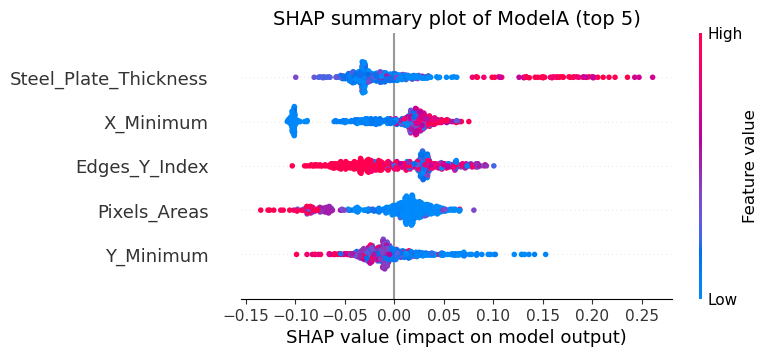

In [185]:
# modelA, modelB 따로 해석
explainer = shap.TreeExplainer(multiple_modelA,
                               data=X3_train)
shap_values = explainer(X3_test)
feature_names = X3_test.columns.str.replace('standardscaler__','').str.replace('onehotencoder__','')
shap.summary_plot(shap_values, 
                  feature_names=feature_names,
                  max_display=5,
                  show=False)
plt.title('SHAP summary plot of ModelA (top 5)', fontsize=14)
plt.show()

In [187]:
class MultipleMixed:
    def __init__(self, modelA, modelB):
        self.modelA = modelA
        self.modelB = modelB

    def fit(self, X_train, y_train):
        y_trainA = y_train.apply(lambda x: np.where(x == 6, 1, 0))
        y_trainB = y_train[y_train != 6]
        X_trainB = X_trainB.loc[y_trainB.index]

        self.modelA.fit(X_train, y_trainA, verbose=0)
        self.modelB.fit(X_trainB, y_trainB, verbose=0)

    def predict(self, X_test):
        modelA = self.modelA
        modelB = self.modelB

        pred1 = np.where(modelA.predict(X_test), 6, 0)
        pred1 = pd.Series(pred1, index=X_test.index, name='label')

        idx = pred1[pred1 == 0].index
        pred2 = modelB.predict(X_test.loc[idx])
        pred2 = pd.Series(pred2, index=idx, name='label')

        pred1.update(pred2)
        return pred1.to_numpy()
    
multiple_mixed = MultipleMixed(multiple_modelA, multiple_modelB)

pi = permutation_importance(multiple_mixed, X3_test, y3_test.label,
                            n_repeats=20,
                            scoring='f1_macro',
                            random_state=42,
                            n_jobs=-1)

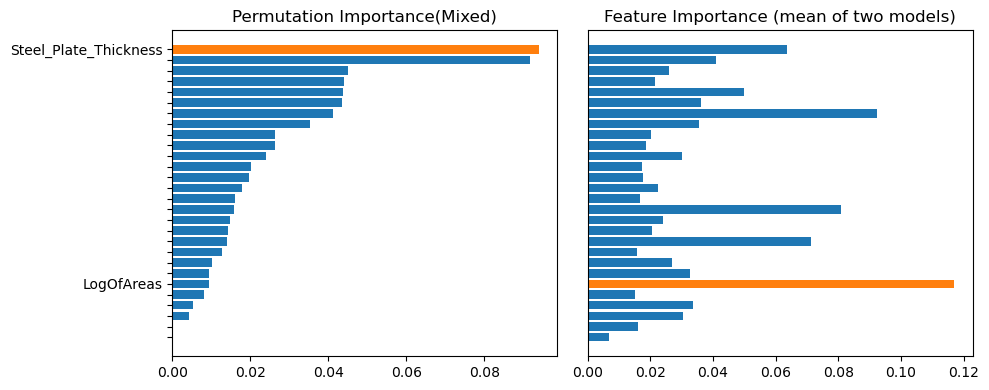

In [205]:
# Permutation importanc, PDP 그려보기
pi_series = pd.Series(pi.importances_mean, index=feature_names).sort_values()
fi = (multiple_modelA.feature_importances_ + multiple_modelB.feature_importances_) / 2
fi_series = pd.Series(fi, index=feature_names)[pi_series.index]
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.barh(pi_series.index, pi_series.values, color=['C1' if i==27 else 'C0' for i in range(28)])
plt.yticks(range(28), [pi_series.index[i] if i==27 or i==5 else '' for i in range(28)])
plt.title('Permutation Importance(Mixed)', fontsize=12)
plt.subplot(122)
plt.barh(fi_series.index, fi_series.values, color=['C1' if i==5 else 'C0' for i in range(28)] )
plt.yticks([])
plt.title('Feature Importance (mean of two models)', fontsize=12)
plt.tight_layout()
plt.show()
# Steel_Plate_Thickness가 PI에선중요
# LogOfAreas가 두 모델의 FI 평균에선 중요
# => SHAP도 Thickness를 최우선으로 판단했으므로, 이것을 가지고 PDP 그려보기

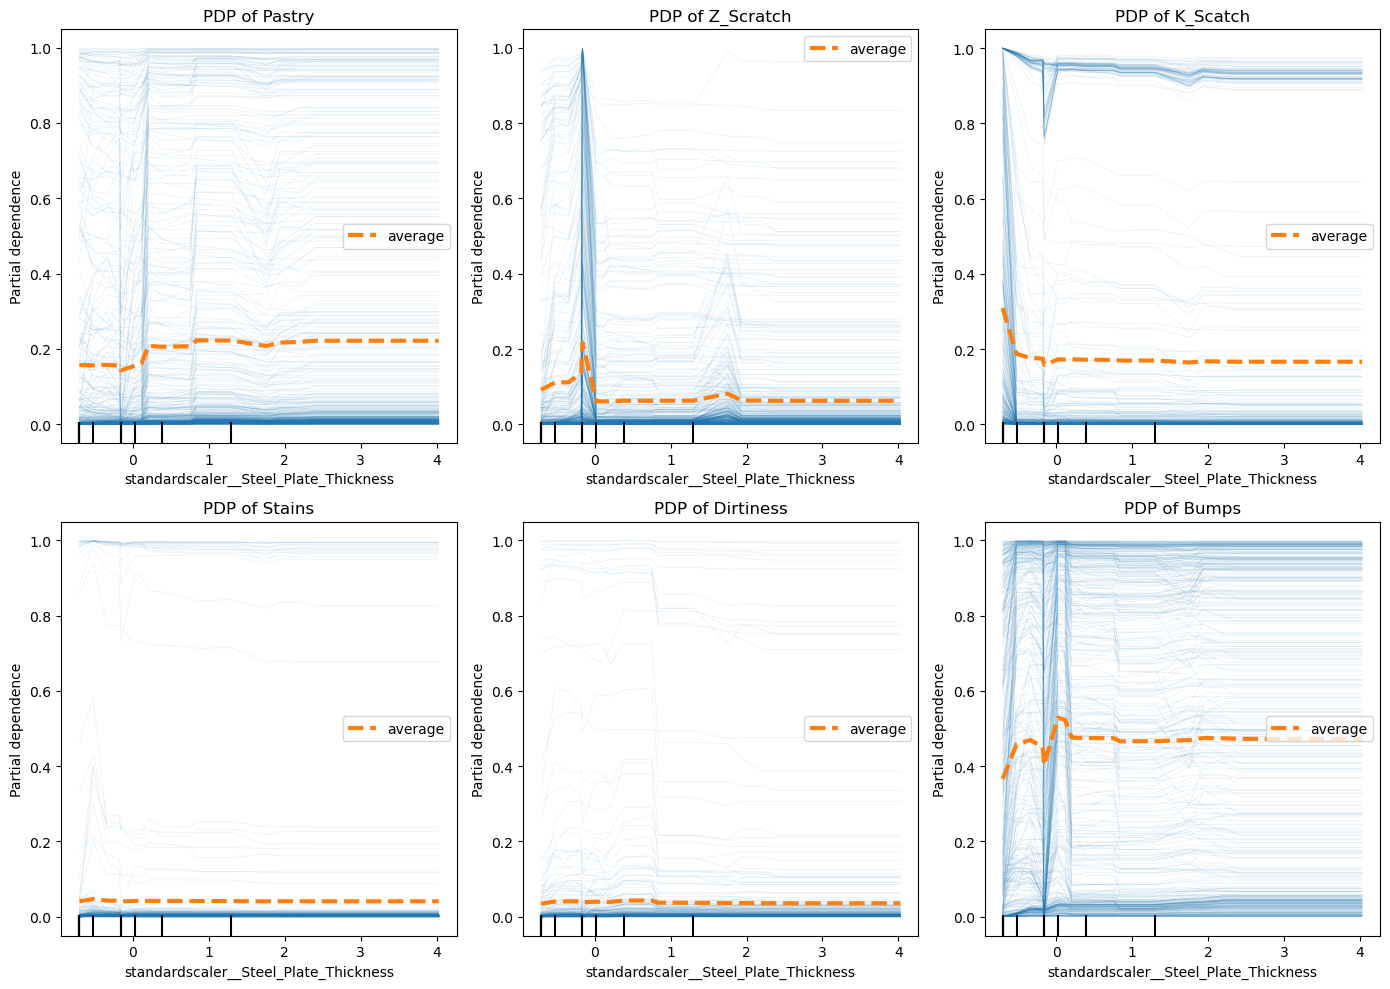

In [207]:
# 1way PDP 그려보기
fig, axs = plt.subplots(2, 3, figsize=(14, 10))
target_list = list(y3_test)
for i, ax in enumerate(axs.ravel()):
    PartialDependenceDisplay.from_estimator(multiple_modelB,
                                            X=X3_test,
                                            features=[11],
                                            target=i,
                                            ice_lines_kw={'alpha':0.1},
                                            pd_line_kw={'linewidth':3},
                                            kind='both',
                                            ax=ax,
                                            n_jobs=-1)
    ax.set_title(f'PDP of {target_list[i]}', fontsize=12)
plt.tight_layout()
plt.show()

# 특정 결함 (Ex.Bumps)에는 영향을 미치지만, 별 영향없는 결함들도 있다.
# 영향있는 결함도 편차가 크다. => feature의 영향력이 독립적이지 않다.
# Thickness가 평균보다 많이 커지면 영향력이 사라진다.
# => 일정이상의 Thickness는 판단에 별로 중요하지 않다.

In [78]:
# joblib.dump(multiple_modelA, 'data/multi_BestModel.pkl')
# joblib.dump(multiple_modelB, 'data/multi_BestModel2.pkl')
# joblib.dump(data3_ct, 'data/multi_ct.pkl')

['data/multi_ct.pkl']

### 튜닝결과

* XGBoost 채용
* 이진분류 acc : 0.844
* 다중분류 micro-f1 : 0.934
* 두모델 총합 f1 : micro 0.81, macro 0.82